In [40]:
from sqlalchemy import create_engine
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Connection information
server = "COMPUTER"
database = "FootballDB"

# Connect to SQL Server using the pymssql driver
conn_str = (
    f"mssql+pyodbc://@{server}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)
engine = create_engine(conn_str)


## Market Analysis

In [42]:
query = """
WITH CTE AS(
SELECT
	SUM(a.minutes_played) AS total_minutes_plays,
	SUM(a.goals) AS total_goals,
	SUM(a.assists) AS total_assists,
	SUM(a.yellow_cards) AS total_yellow,
	SUM(a.red_cards) AS total_red,
	p.player_id,
	p.name AS player_name,
	DATEDIFF(year, p.date_of_birth, '2016-05-29') AS ages, 
	p.sub_position,
	p.foot,
	c.name AS club_name
FROM
	appearances a
	JOIN players p ON a.player_id = p.player_id
	JOIN clubs c ON a.player_club_id = c.club_id
GROUP BY
	p.player_id,
	p.name,
	DATEDIFF(year, p.date_of_birth, '2016-05-29'), 
	p.sub_position,
	p.foot,
	c.name
),
CTE2 AS(
SELECT
	*,
	((CAST(total_goals AS FLOAT) + total_assists)/total_minutes_plays)*90 AS ga_90
FROM
	CTE
ORDER BY
	total_goals DESC, 
	total_assists DESC
OFFSET 0 ROWS FETCH NEXT 200 ROWS ONLY
),
CTE3 AS(
SELECT
	player_id,
	date,
	market_value_in_eur
FROM
	(SELECT
		*,
		ROW_NUMBER() OVER(PARTITION BY player_id ORDER BY date DESC) AS rn
	FROM
		player_valuations
	WHERE
		date BETWEEN '2015-01-01' AND (SELECT MAX(date) FROM games)) AS subquery
WHERE
	rn = 1
)
SELECT
	c2.total_goals,
	c2.total_assists,
	c2.ga_90,
	c2.player_id,
	c2.player_name,
	c2.ages,
	c2.sub_position,
	c2.foot,
	c2.club_name,
	c3.market_value_in_eur
FROM
	CTE2 c2
	JOIN CTE3 c3 ON c2.player_id = c3.player_id
WHERE
	c2.sub_position LIKE 'Right Winger'
ORDER BY
	c2.total_goals DESC,
	c2.total_assists DESC,
	c3.market_value_in_eur;
"""
df_tables = pd.read_sql(query, engine)

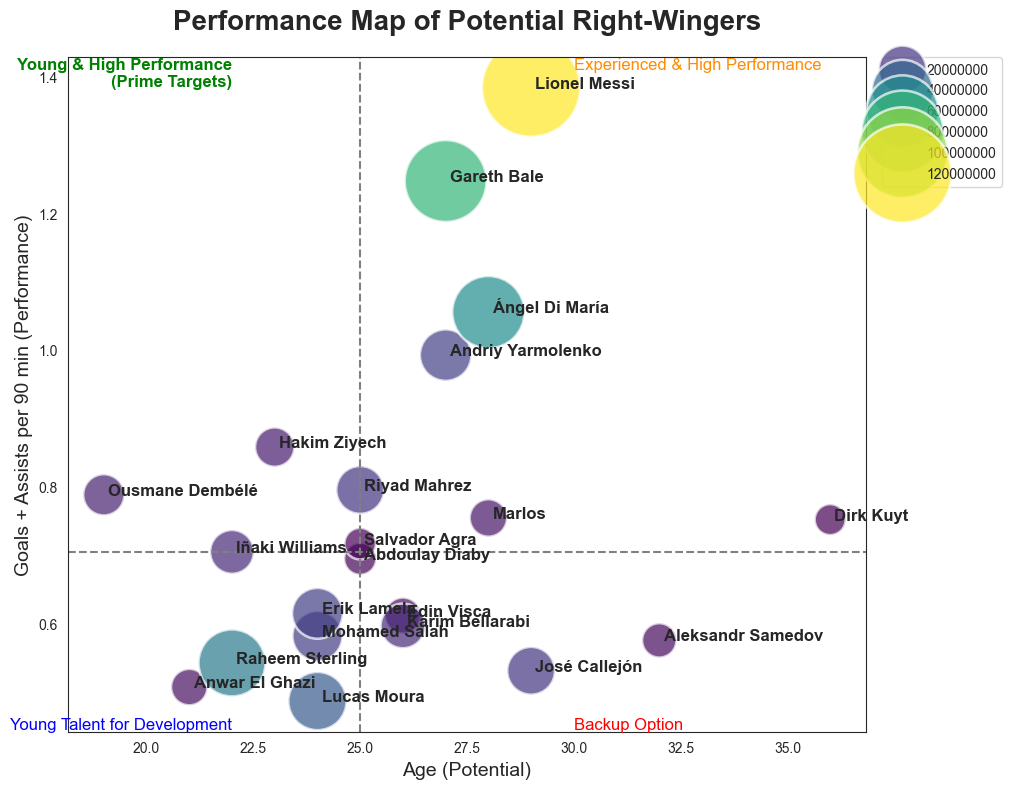

In [43]:
# Setup
sns.set_style("white") 
fig, ax = plt.subplots(figsize=(12, 8))

# Bubble plot
sns.scatterplot(
    data=df_tables,
    x="ages",
    y="ga_90",
    size="market_value_in_eur",
    hue="market_value_in_eur",  
    sizes=(500, 5000),
    alpha=0.7,
    palette="viridis",
    ax=ax
)

# Player labels
for _, row in df_tables.iterrows():
    ax.text(row['ages'] + 0.1, row['ga_90'], row['player_name'], fontsize=12, fontweight='bold')

# Median lines & quadrant labels
median_age = df_tables['ages'].median()
median_ga90 = df_tables['ga_90'].median()
ax.axvline(median_age, color='grey', linestyle='--', lw=1.5)
ax.axhline(median_ga90, color='grey', linestyle='--', lw=1.5)

ax.text(median_age - 3, ax.get_ylim()[1], 'Young & High Performance\n(Prime Targets)', 
        ha='right', va='top', fontsize=12, color='green', fontweight='bold')
ax.text(median_age + 5, ax.get_ylim()[1], 'Experienced & High Performance', 
        ha='left', va='top', fontsize=12, color='darkorange')
ax.text(median_age - 3, ax.get_ylim()[0], 'Young Talent for Development', 
        ha='right', va='bottom', fontsize=12, color='blue')
ax.text(median_age + 5, ax.get_ylim()[0], 'Backup Option', 
        ha='left', va='bottom', fontsize=12, color='red')

# Titles & labels
ax.set_title('Performance Map of Potential Right-Wingers', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Age (Potential)', fontsize=14)
ax.set_ylabel('Goals + Assists per 90 min (Performance)', fontsize=14)

# Legend outside
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 1])

## Target 1: Ousmane Dembélé'

### Info

In [44]:
query_dembele_info = """
WITH player_values AS(
SELECT
	player_id,
	date,
	market_value_in_eur
FROM
	(SELECT
		*,
		ROW_NUMBER() OVER(PARTITION BY player_id ORDER BY date DESC) AS rn
	FROM
		player_valuations
	WHERE
		date BETWEEN '2015-01-01' AND (SELECT MAX(date) FROM games)) AS subquery
WHERE
	rn = 1
)
SELECT DISTINCT
	p.name AS player_name, 
	p.date_of_birth,
	p.height_in_cm,
	p.sub_position,
	p.country_of_citizenship,
	c.name AS club_name, 
	pv.market_value_in_eur
FROM
	game_lineups gl
	JOIN players p ON gl.player_id = p.player_id
	JOIN clubs c ON gl.club_id = c.club_id
	JOIN player_values pv ON pv.player_id = p.player_id
WHERE
	p.player_id = 288230
"""
dembele_info = pd.read_sql(query_dembele_info, engine)

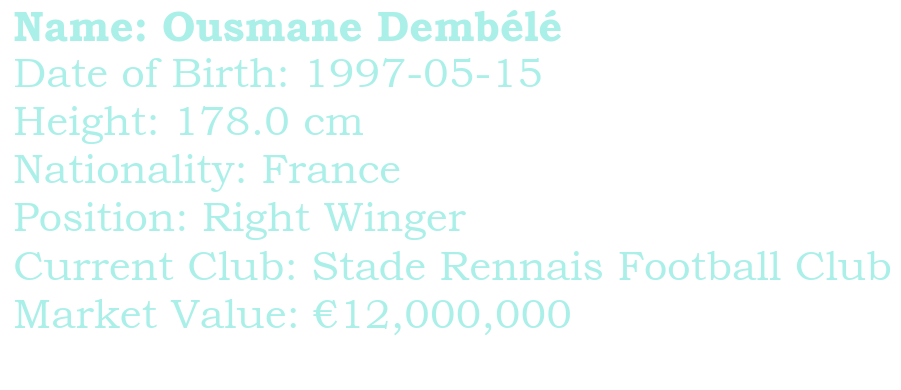

In [45]:
dembele_info = dembele_info.iloc[0]

# Info lines (Height with cm, Market Value with €)
info_lines = [
    f"Name: {dembele_info['player_name']}",
    f"Date of Birth: {pd.to_datetime(dembele_info['date_of_birth']).strftime('%Y-%m-%d')}",
    f"Height: {dembele_info['height_in_cm']} cm",
    f"Nationality: {dembele_info['country_of_citizenship']}",
    f"Position: {dembele_info['sub_position']}",
    f"Current Club: {dembele_info['club_name']}",
    f"Market Value: €{dembele_info['market_value_in_eur']:,}"
]

# Create figure & axis
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')

# --- Background setup ---
# Outer background transparent
fig.patch.set_alpha(0)
# Inner background:
ax.set_facecolor('none')

# Add white text
for i, line in enumerate(info_lines):
    ax.text(
        0.02, 1 - (i * 0.13),
        line,
        fontsize=30,
        fontname='Bookman Old Style',
        color='#AAF0E9',
        ha='left',
        va='top',
        fontweight='bold' if i == 0 else 'normal'
    )

plt.tight_layout()
plt.show()


### Goal types

In [46]:
query_dembele_goal_types = """
SELECT
	player_id, 
	goal_types,
	COUNT(*) AS goal_type_count
FROM
	game_events
WHERE
	player_id = 288230 AND
	type LIKE 'Goals'
GROUP BY
	player_id, 
	goal_types
ORDER BY
	player_id
"""
dembele_goal_types = pd.read_sql(query_dembele_goal_types, engine)

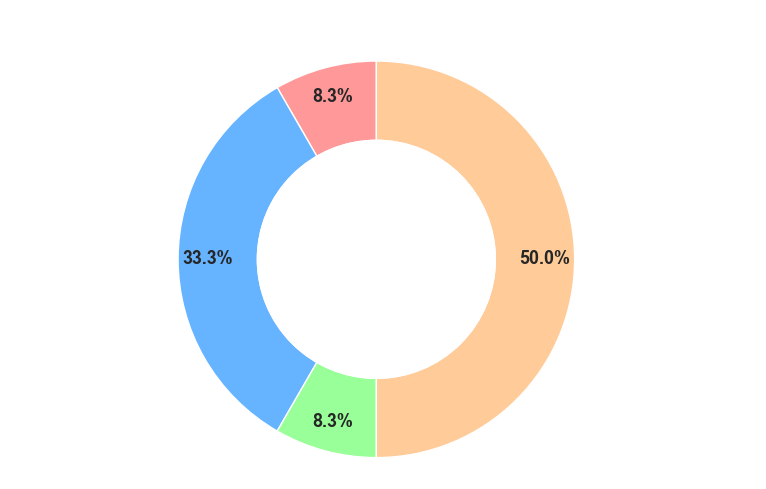

In [47]:
# Plotting 
labels = dembele_goal_types['goal_types']
sizes = dembele_goal_types['goal_type_count']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

fig, ax = plt.subplots(figsize=(8, 5))

# Remove background
fig.patch.set_alpha(0)  
ax.set_facecolor("none")  

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Create a white circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

# Adjust text sizes
plt.setp(texts, size=14, color = 'white',fontweight='bold')       # Label text
plt.setp(autotexts, size=13, weight='bold')       # Percentage text

# Final Touches
ax.axis('equal')  
plt.title("Ousmane Dembélé's Goalscoring DNA", color = 'white', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()


### Assist types

In [48]:
query_dembele_assist_types = """
SELECT
	player_assist_id, 
	assist_types,
	COUNT(*) AS assist_type_count
FROM
	game_events
WHERE
	player_assist_id = 288230 AND
	type LIKE 'Goals'
GROUP BY
	player_assist_id, 
	assist_types
ORDER BY
	player_assist_id
"""
dembele_assist_types = pd.read_sql(query_dembele_assist_types, engine)

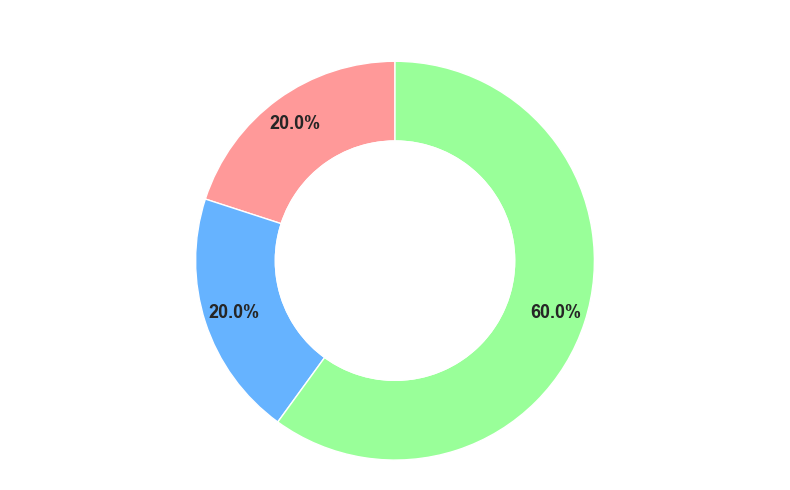

In [49]:
# Plotting 
labels = dembele_assist_types['assist_types']
sizes = dembele_assist_types['assist_type_count']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

fig, ax = plt.subplots(figsize=(8, 5))

# Remove background
fig.patch.set_alpha(0)  
ax.set_facecolor("none")  

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Create a white circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

# Adjust text sizes
plt.setp(texts, size=14, color = 'white',fontweight='bold')       # Label text
plt.setp(autotexts, size=13, weight='bold')       # Percentage text

# Final Touches
ax.axis('equal')  
plt.title("Ousmane Dembélé's Playmaking DNA", color = 'white', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()


### Tactical Formations

In [50]:
query_dembele_tactical_formations = """
WITH home_formations AS(
SELECT
	p.player_id,
	p.name AS player_name,
	gl.position,
	g.home_club_formation,	
	COUNT(*) AS formation_count
FROM
	players p
	JOIN game_lineups gl ON p.player_id = gl.player_id
	JOIN games g ON gl.game_id = g.game_id AND (g.home_club_id = gl.club_id OR g.away_club_id = gl.club_id)
GROUP BY
	p.player_id,
	p.name,
	gl.position,
	g.home_club_formation
HAVING
	p.player_id IN (217111, 171424, 148455, 288230)
),

away_formations AS(
SELECT
	p.player_id,
	p.name AS player_name,
	gl.position,
	g.away_club_formation,	
	COUNT(*) AS formation_count
FROM
	players p
	JOIN game_lineups gl ON p.player_id = gl.player_id
	JOIN games g ON gl.game_id = g.game_id AND (g.home_club_id = gl.club_id OR g.away_club_id = gl.club_id)
GROUP BY
	p.player_id,
	p.name,
	gl.position,
	g.away_club_formation
HAVING
	p.player_id IN (217111, 171424, 148455, 288230)
)

SELECT 
    player_id,
    player_name,
    position,
    formation,
    SUM(formation_count) AS total_formation_count
FROM (
    SELECT 
        player_id,
        player_name,
        position,
        away_club_formation AS formation,
        formation_count
    FROM away_formations

    UNION ALL

    SELECT 
        player_id,
        player_name,
        position,
        home_club_formation AS formation,
        formation_count
    FROM home_formations
) AS combined
GROUP BY 
    player_id,
    player_name,
    position,
    formation
HAVING
	player_id = 288230
ORDER BY 
    player_id, player_name, position, formation;
"""
dembele_tactical_formations = pd.read_sql(query_dembele_tactical_formations, engine)

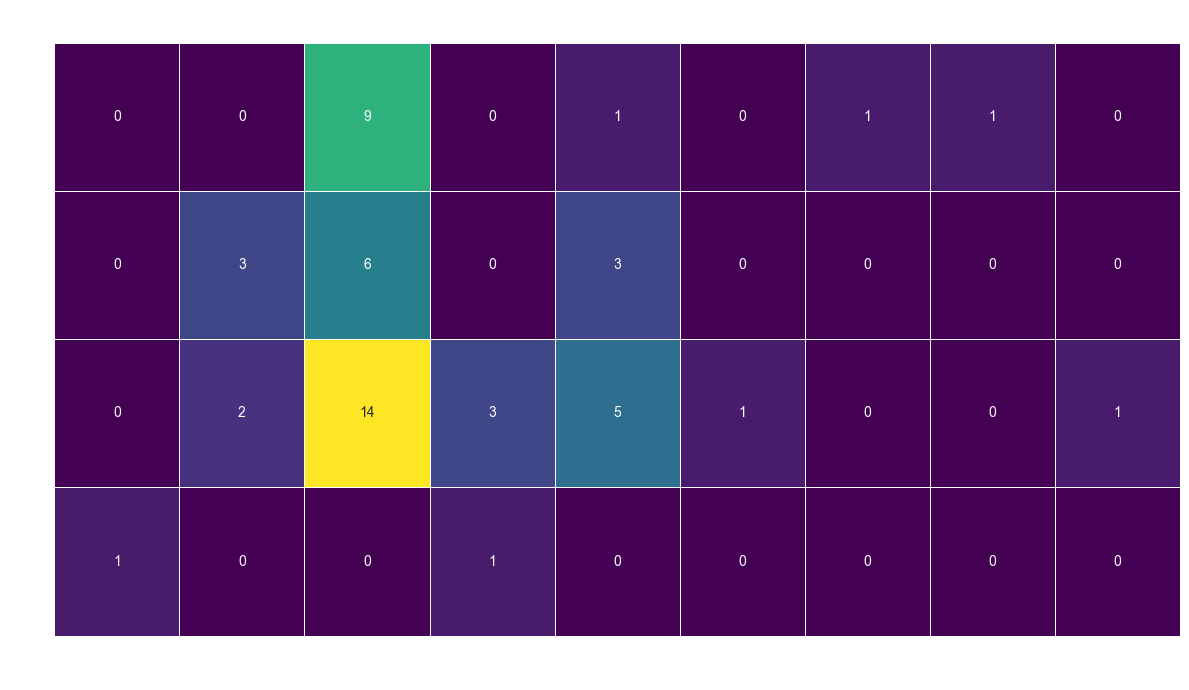

In [51]:
# Create a matrix with positions as rows and formations as columns
pivot_df = dembele_tactical_formations.pivot_table(index='position', columns='formation', values='total_formation_count', fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(
    pivot_df,
    annot=True,
    cmap="viridis", 
    linewidths=.5,
    cbar=False,      
)

# Remove background
fig.patch.set_alpha(0)      
ax.set_facecolor("none")  

# Final Touches
ax.set_title("Ousmane Dembélé's Tactical Heatmap", color = 'white', fontsize=24, fontweight='bold')
ax.set_xlabel("Formation", fontsize=12, color = 'white')
ax.set_ylabel("Position", fontsize=12, color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()
plt.show()

## Target 2: Hakim Ziyech

### Info

In [52]:
query_ziyech_info = """
WITH player_values AS(
SELECT
	player_id,
	date,
	market_value_in_eur
FROM
	(SELECT
		*,
		ROW_NUMBER() OVER(PARTITION BY player_id ORDER BY date DESC) AS rn
	FROM
		player_valuations
	WHERE
		date BETWEEN '2015-01-01' AND (SELECT MAX(date) FROM games)) AS subquery
WHERE
	rn = 1
)
SELECT DISTINCT
	p.name AS player_name, 
	p.date_of_birth,
	p.height_in_cm,
	p.sub_position,
	p.country_of_citizenship,
	c.name AS club_name, 
	pv.market_value_in_eur
FROM
	game_lineups gl
	JOIN players p ON gl.player_id = p.player_id
	JOIN clubs c ON gl.club_id = c.club_id
	JOIN player_values pv ON pv.player_id = p.player_id
WHERE
	p.player_id = 217111
"""
ziyech_info = pd.read_sql(query_ziyech_info, engine)

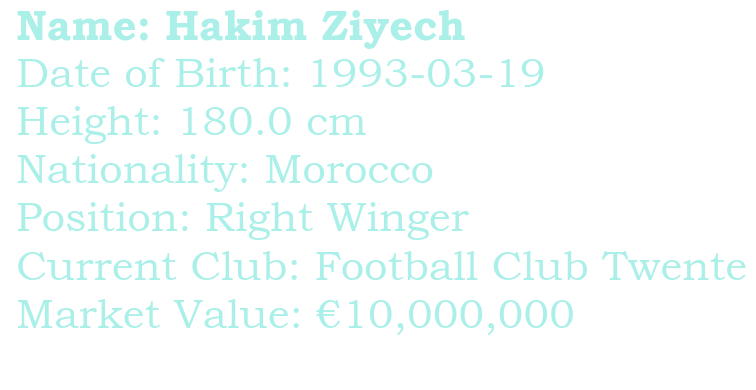

In [53]:
ziyech_info = ziyech_info.iloc[0]

# Info lines (Height with cm, Market Value with €)
info_lines = [
    f"Name: {ziyech_info['player_name']}",
    f"Date of Birth: {pd.to_datetime(ziyech_info['date_of_birth']).strftime('%Y-%m-%d')}",
    f"Height: {ziyech_info['height_in_cm']} cm",
    f"Nationality: {ziyech_info['country_of_citizenship']}",
    f"Position: {ziyech_info['sub_position']}",
    f"Current Club: {ziyech_info['club_name']}",
    f"Market Value: €{ziyech_info['market_value_in_eur']:,}"
]

# Create figure & axis
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')

# --- Background setup ---
# Outer background transparent
fig.patch.set_alpha(0)
# Inner background:
ax.set_facecolor('none')

# Add white text
for i, line in enumerate(info_lines):
    ax.text(
        0.02, 1 - (i * 0.13),
        line,
        fontsize=30,
        fontname='Bookman Old Style',
        color='#AAF0E9',
        ha='left',
        va='top',
        fontweight='bold' if i == 0 else 'normal'
    )

plt.tight_layout()
plt.show()


### Goal types

In [54]:
query_ziyech_goal_types = """
SELECT
	player_id, 
	goal_types,
	COUNT(*) AS goal_type_count
FROM
	game_events
WHERE
	player_id = 217111 AND
	type LIKE 'Goals'
GROUP BY
	player_id, 
	goal_types
ORDER BY
	player_id
"""
ziyech_goal_types = pd.read_sql(query_ziyech_goal_types, engine)

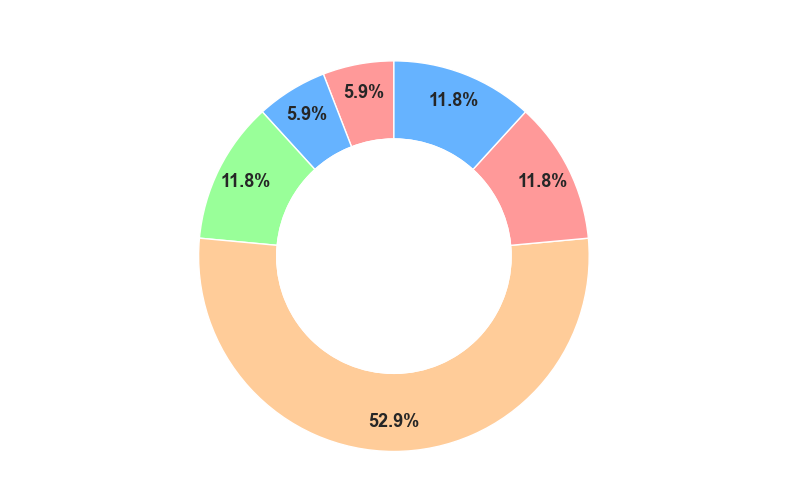

In [55]:
# Plotting 
labels = ziyech_goal_types['goal_types']
sizes = ziyech_goal_types['goal_type_count']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

fig, ax = plt.subplots(figsize=(8, 5))

# Remove background
fig.patch.set_alpha(0)  
ax.set_facecolor("none")  

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Create a white circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

# Adjust text sizes
plt.setp(texts, size=14, color = 'white',fontweight='bold')       # Label text
plt.setp(autotexts, size=13, weight='bold')       # Percentage text

# Final Touches
ax.axis('equal')  
plt.title("Hakim Ziyech's Goalscoring DNA", color = 'white', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()


### Assist types

In [56]:
query_ziyech_assist_types = """
SELECT
	player_assist_id, 
	assist_types,
	COUNT(*) AS assist_type_count
FROM
	game_events
WHERE
	player_assist_id = 217111 AND
	type LIKE 'Goals'
GROUP BY
	player_assist_id, 
	assist_types
ORDER BY
	player_assist_id
"""
ziyech_assist_types = pd.read_sql(query_ziyech_assist_types, engine)

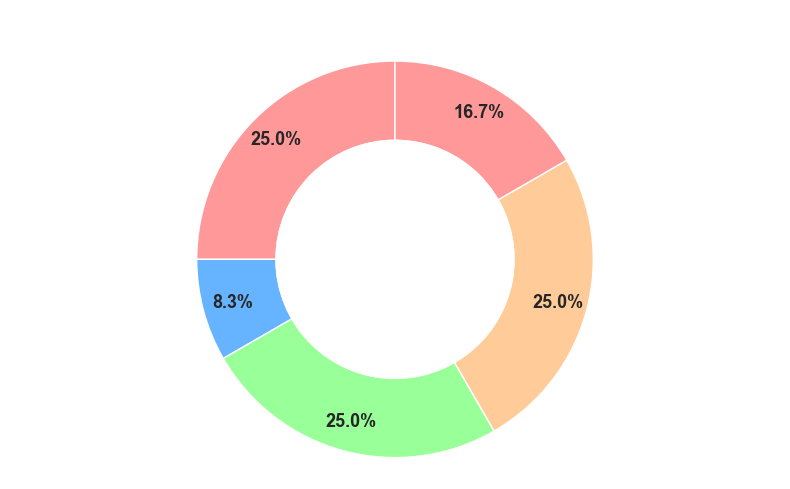

In [57]:
# Plotting 
labels = ziyech_assist_types['assist_types']
sizes = ziyech_assist_types['assist_type_count']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

fig, ax = plt.subplots(figsize=(8, 5))

# Remove background
fig.patch.set_alpha(0)  
ax.set_facecolor("none")  

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Create a white circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

# Adjust text sizes
plt.setp(texts, size=14, color = 'white',fontweight='bold')       # Label text
plt.setp(autotexts, size=13, weight='bold')       # Percentage text

# Final Touches
ax.axis('equal')  
plt.title("Hakim Ziyech's Playmaking DNA", color = 'white', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

### Tactical Formations

In [58]:
query_ziyech_tactical_formations = """
WITH home_formations AS(
SELECT
	p.player_id,
	p.name AS player_name,
	gl.position,
	g.home_club_formation,	
	COUNT(*) AS formation_count
FROM
	players p
	JOIN game_lineups gl ON p.player_id = gl.player_id
	JOIN games g ON gl.game_id = g.game_id AND (g.home_club_id = gl.club_id OR g.away_club_id = gl.club_id)
GROUP BY
	p.player_id,
	p.name,
	gl.position,
	g.home_club_formation
HAVING
	p.player_id IN (217111, 171424, 148455, 288230)
),

away_formations AS(
SELECT
	p.player_id,
	p.name AS player_name,
	gl.position,
	g.away_club_formation,	
	COUNT(*) AS formation_count
FROM
	players p
	JOIN game_lineups gl ON p.player_id = gl.player_id
	JOIN games g ON gl.game_id = g.game_id AND (g.home_club_id = gl.club_id OR g.away_club_id = gl.club_id)
GROUP BY
	p.player_id,
	p.name,
	gl.position,
	g.away_club_formation
HAVING
	p.player_id IN (217111, 171424, 148455, 288230)
)

SELECT 
    player_id,
    player_name,
    position,
    formation,
    SUM(formation_count) AS total_formation_count
FROM (
    SELECT 
        player_id,
        player_name,
        position,
        away_club_formation AS formation,
        formation_count
    FROM away_formations

    UNION ALL

    SELECT 
        player_id,
        player_name,
        position,
        home_club_formation AS formation,
        formation_count
    FROM home_formations
) AS combined
GROUP BY 
    player_id,
    player_name,
    position,
    formation
HAVING
	player_id = 217111
ORDER BY 
    player_id, player_name, position, formation;
"""
ziyech_tactical_formations = pd.read_sql(query_ziyech_tactical_formations, engine)

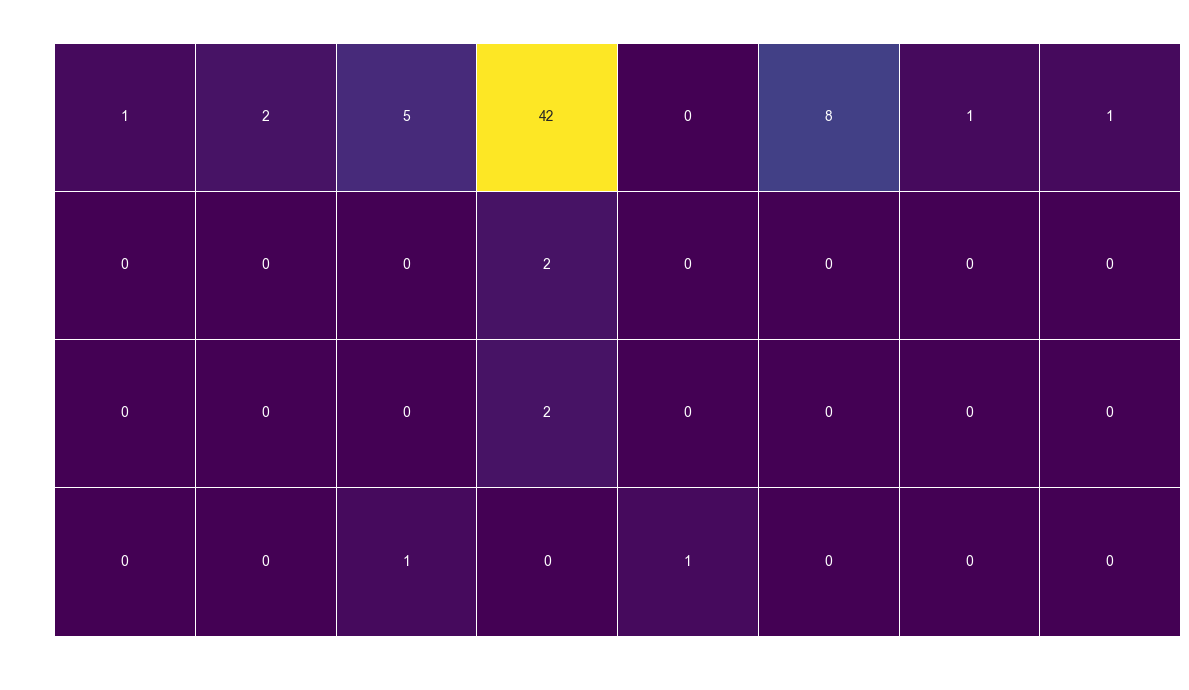

In [59]:
# Create a matrix with positions as rows and formations as columns
pivot_df = ziyech_tactical_formations.pivot_table(index='position', columns='formation', values='total_formation_count', fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(
    pivot_df,
    annot=True,
    cmap="viridis", 
    linewidths=.5,
    cbar=False,      
)

# Remove background
fig.patch.set_alpha(0)      
ax.set_facecolor("none")  

# Final Touches
ax.set_title("Hakim Ziyech's Tactical Heatmap", color = 'white', fontsize=24, fontweight='bold')
ax.set_xlabel("Formation", fontsize=12, color = 'white')
ax.set_ylabel("Position", fontsize=12, color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()
plt.show()

## Target 3: Riyad Mahrez

### Info

In [60]:
query_mahrez_info = """
WITH player_values AS(
SELECT
	player_id,
	date,
	market_value_in_eur
FROM
	(SELECT
		*,
		ROW_NUMBER() OVER(PARTITION BY player_id ORDER BY date DESC) AS rn
	FROM
		player_valuations
	WHERE
		date BETWEEN '2015-01-01' AND (SELECT MAX(date) FROM games)) AS subquery
WHERE
	rn = 1
)
SELECT DISTINCT
	p.name AS player_name, 
	p.date_of_birth,
	p.height_in_cm,
	p.sub_position,
	p.country_of_citizenship,
	c.name AS club_name, 
	pv.market_value_in_eur
FROM
	game_lineups gl
	JOIN players p ON gl.player_id = p.player_id
	JOIN clubs c ON gl.club_id = c.club_id
	JOIN player_values pv ON pv.player_id = p.player_id
WHERE
	p.player_id = 171424
"""
mahrez_info = pd.read_sql(query_mahrez_info, engine)

In [61]:
mahrez_info['country_of_citizenship'] = 'Algerian'

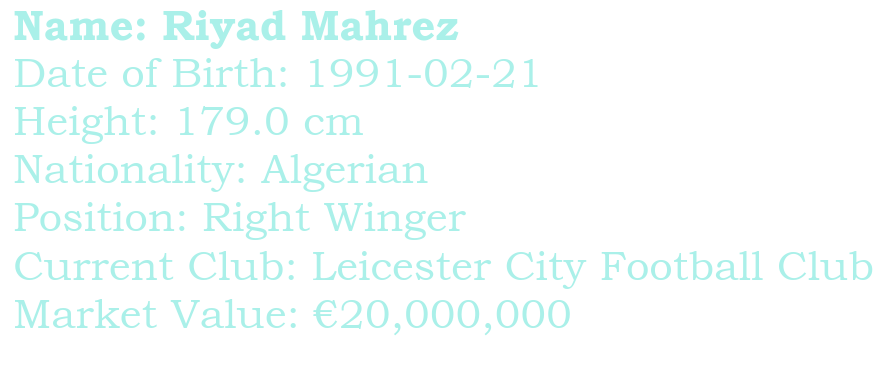

In [62]:
mahrez_info = mahrez_info.iloc[0]

# Info lines (Height with cm, Market Value with €)
info_lines = [
    f"Name: {mahrez_info['player_name']}",
    f"Date of Birth: {pd.to_datetime(mahrez_info['date_of_birth']).strftime('%Y-%m-%d')}",
    f"Height: {mahrez_info['height_in_cm']} cm",
    f"Nationality: {mahrez_info['country_of_citizenship']}",
    f"Position: {mahrez_info['sub_position']}",
    f"Current Club: {mahrez_info['club_name']}",
    f"Market Value: €{mahrez_info['market_value_in_eur']:,}"
]

# Create figure & axis
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')

# --- Background setup ---
# Outer background transparent
fig.patch.set_alpha(0)
# Inner background:
ax.set_facecolor('none')

# Add white text
for i, line in enumerate(info_lines):
    ax.text(
        0.02, 1 - (i * 0.13),
        line,
        fontsize=30,
        fontname='Bookman Old Style',
        color='#AAF0E9',
        ha='left',
        va='top',
        fontweight='bold' if i == 0 else 'normal'
    )

plt.tight_layout()
plt.show()


### Goal types

In [63]:
query_mahrez_goal_types = """
SELECT
	player_id, 
	goal_types,
	COUNT(*) AS goal_type_count
FROM
	game_events
WHERE
	player_id = 171424 AND
	type LIKE 'Goals'
GROUP BY
	player_id, 
	goal_types
ORDER BY
	player_id
"""
mahrez_goal_types = pd.read_sql(query_mahrez_goal_types, engine)

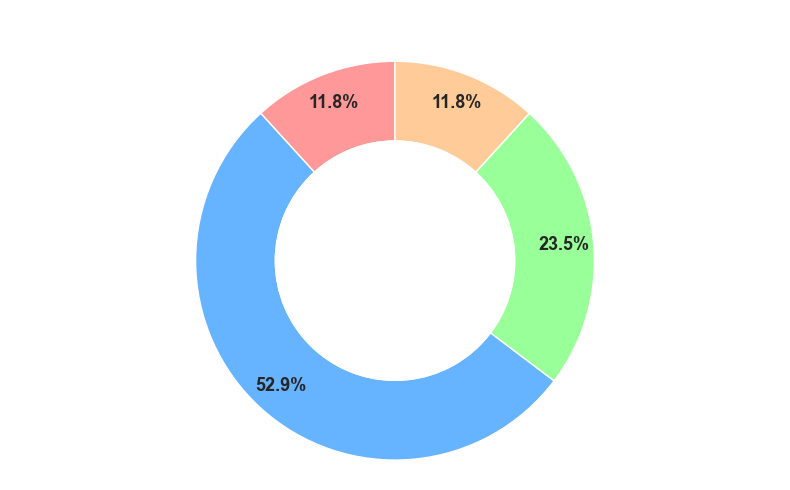

In [64]:
# Plotting 
labels = mahrez_goal_types['goal_types']
sizes = mahrez_goal_types['goal_type_count']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

fig, ax = plt.subplots(figsize=(8, 5))

# Remove background
fig.patch.set_alpha(0)  
ax.set_facecolor("none")  

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Create a white circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

# Adjust text sizes
plt.setp(texts, size=14, color = 'white',fontweight='bold')       # Label text
plt.setp(autotexts, size=13, weight='bold')       # Percentage text

# Final Touches
ax.axis('equal')  
plt.title("Riyad Mahrez's Goalscoring DNA", color = 'white', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()


### Assist types

In [65]:
query_mahrez_assist_types = """
SELECT
	player_assist_id, 
	assist_types,
	COUNT(*) AS assist_type_count
FROM
	game_events
WHERE
	player_assist_id = 171424 AND
	type LIKE 'Goals'
GROUP BY
	player_assist_id, 
	assist_types
ORDER BY
	player_assist_id
"""
mahrez_assist_types = pd.read_sql(query_mahrez_assist_types, engine)

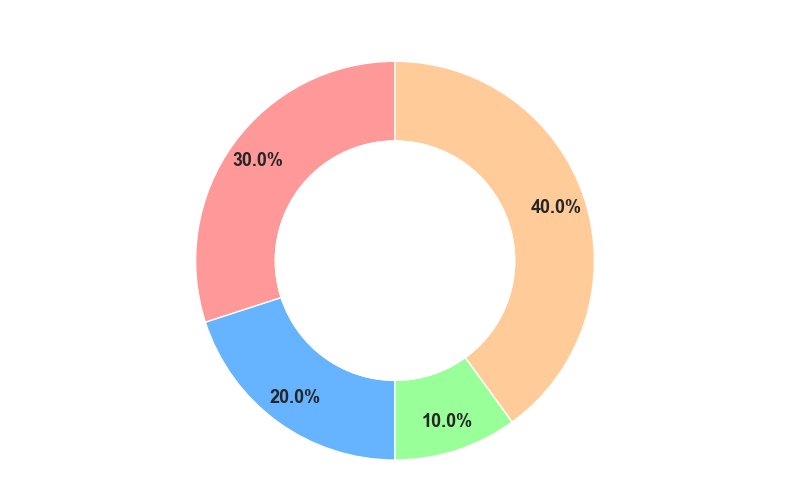

In [66]:
# Plotting 
labels = mahrez_assist_types['assist_types']
sizes = mahrez_assist_types['assist_type_count']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

fig, ax = plt.subplots(figsize=(8, 5))

# Remove background
fig.patch.set_alpha(0)  
ax.set_facecolor("none")  

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Create a white circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

# Adjust text sizes
plt.setp(texts, size=14, color = 'white',fontweight='bold')       # Label text
plt.setp(autotexts, size=13, weight='bold')       # Percentage text

# Final Touches
ax.axis('equal')  
plt.title("Riyad Mahrez's Playmaking DNA", color = 'white', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

### Tactical Formations

In [67]:
query_mahrez_tactical_formations = """
WITH home_formations AS(
SELECT
	p.player_id,
	p.name AS player_name,
	gl.position,
	g.home_club_formation,	
	COUNT(*) AS formation_count
FROM
	players p
	JOIN game_lineups gl ON p.player_id = gl.player_id
	JOIN games g ON gl.game_id = g.game_id AND (g.home_club_id = gl.club_id OR g.away_club_id = gl.club_id)
GROUP BY
	p.player_id,
	p.name,
	gl.position,
	g.home_club_formation
HAVING
	p.player_id IN (217111, 171424, 148455, 288230)
),

away_formations AS(
SELECT
	p.player_id,
	p.name AS player_name,
	gl.position,
	g.away_club_formation,	
	COUNT(*) AS formation_count
FROM
	players p
	JOIN game_lineups gl ON p.player_id = gl.player_id
	JOIN games g ON gl.game_id = g.game_id AND (g.home_club_id = gl.club_id OR g.away_club_id = gl.club_id)
GROUP BY
	p.player_id,
	p.name,
	gl.position,
	g.away_club_formation
HAVING
	p.player_id IN (217111, 171424, 148455, 288230)
)

SELECT 
    player_id,
    player_name,
    position,
    formation,
    SUM(formation_count) AS total_formation_count
FROM (
    SELECT 
        player_id,
        player_name,
        position,
        away_club_formation AS formation,
        formation_count
    FROM away_formations

    UNION ALL

    SELECT 
        player_id,
        player_name,
        position,
        home_club_formation AS formation,
        formation_count
    FROM home_formations
) AS combined
GROUP BY 
    player_id,
    player_name,
    position,
    formation
HAVING
	player_id = 171424
ORDER BY 
    player_id, player_name, position, formation;
"""
mahrez_tactical_formations = pd.read_sql(query_mahrez_tactical_formations, engine)

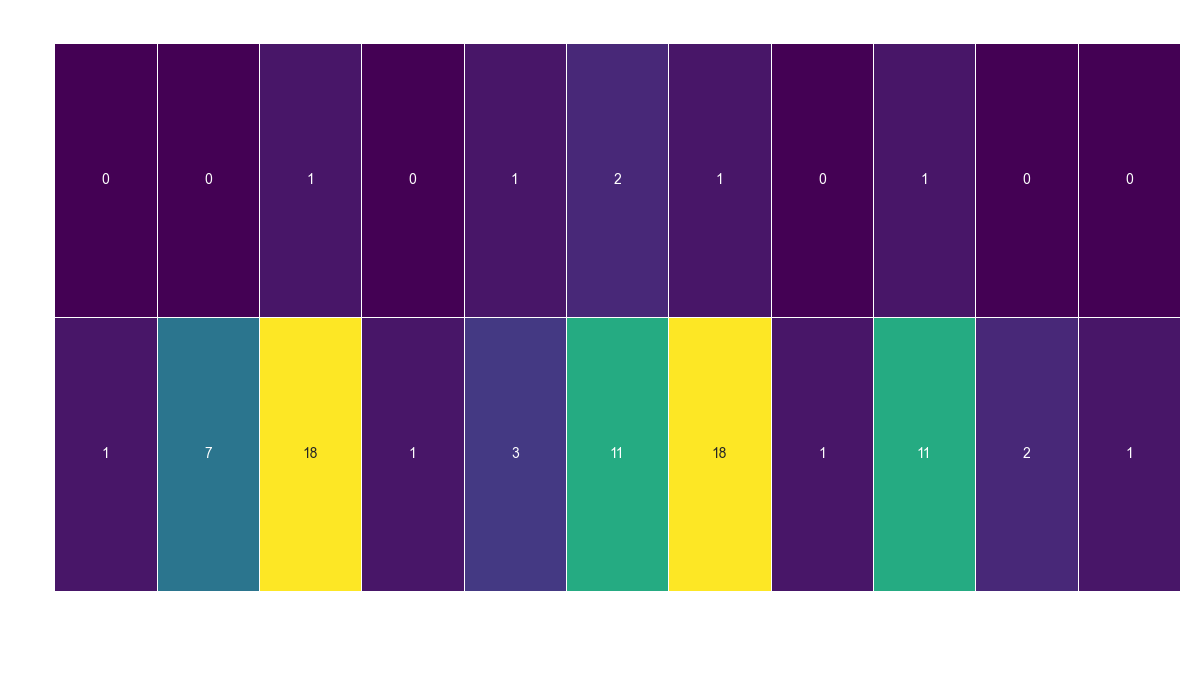

In [68]:
# Create a matrix with positions as rows and formations as columns
pivot_df = mahrez_tactical_formations.pivot_table(index='position', columns='formation', values='total_formation_count', fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(
    pivot_df,
    annot=True,
    cmap="viridis", 
    linewidths=.5,
    cbar=False,      
)

# Remove background
fig.patch.set_alpha(0)      
ax.set_facecolor("none")  

# Final Touches
ax.set_title("Riyad Mahrez's Tactical Heatmap", color = 'white', fontsize=24, fontweight='bold')
ax.set_xlabel("Formation", fontsize=12, color = 'white')
ax.set_ylabel("Position", fontsize=12, color = 'white')
plt.xticks(rotation=30, ha='right', color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()
plt.show()

## Final Comparison

In [69]:
query_summary_data = """
WITH CTE AS(
SELECT
	SUM(a.minutes_played) AS total_minutes_plays,
	SUM(a.goals) AS total_goals,
	SUM(a.assists) AS total_assists,
	SUM(a.yellow_cards) AS total_yellow,
	SUM(a.red_cards) AS total_red,
	p.player_id,
	p.name AS player_name,
	DATEDIFF(year, p.date_of_birth, '2016-05-29') AS ages, 
	p.sub_position,
	p.foot,
	c.name AS club_name
FROM
	appearances a
	JOIN players p ON a.player_id = p.player_id
	JOIN clubs c ON a.player_club_id = c.club_id
GROUP BY
	p.player_id,
	p.name,
	DATEDIFF(year, p.date_of_birth, '2016-05-29'), 
	p.sub_position,
	p.foot,
	c.name
),
CTE2 AS(
SELECT
	*,
	((CAST(total_goals AS FLOAT) + total_assists)/total_minutes_plays)*90 AS ga_90
FROM
	CTE
ORDER BY
	total_goals DESC, 
	total_assists DESC
OFFSET 0 ROWS FETCH NEXT 200 ROWS ONLY
),
CTE3 AS(
SELECT
	player_id,
	date,
	market_value_in_eur
FROM
	(SELECT
		*,
		ROW_NUMBER() OVER(PARTITION BY player_id ORDER BY date DESC) AS rn
	FROM
		player_valuations
	WHERE
		date BETWEEN '2015-01-01' AND (SELECT MAX(date) FROM games)) AS subquery
WHERE
	rn = 1
)
SELECT
	c2.player_id,
	c2.player_name,
	c2.ages,
    c2.ga_90
FROM
	CTE2 c2
WHERE
	c2.sub_position LIKE 'Right Winger'
"""
summary_data = pd.read_sql(query_summary_data, engine)

In [70]:
query_goal_data = """
SELECT
	player_id, 
	goal_types,
	COUNT(*) AS goal_type_count
FROM
	game_events
WHERE
	player_id IN (171424, 217111, 288230) AND
	type LIKE 'Goals'
GROUP BY
	player_id, 
	goal_types
ORDER BY
	player_id   
"""
goal_data = pd.read_sql(query_goal_data, engine)

In [71]:
query_assist_data = """
SELECT
	player_assist_id, 
	assist_types,
	COUNT(*) AS assist_type_count
FROM
	game_events
WHERE
	player_assist_id IN (171424, 217111, 288230) AND
	type LIKE 'Goals'
GROUP BY
	player_assist_id,
	assist_types
ORDER BY
	player_assist_id
"""
assist_data = pd.read_sql(query_assist_data, engine)

In [72]:
query_tactical_data = """
WITH home_formations AS(
SELECT
	p.player_id,
	p.name AS player_name,
	gl.position,
	g.home_club_formation,	
	COUNT(*) AS formation_count
FROM
	players p
	JOIN game_lineups gl ON p.player_id = gl.player_id
	JOIN games g ON gl.game_id = g.game_id AND (g.home_club_id = gl.club_id OR g.away_club_id = gl.club_id)
GROUP BY
	p.player_id,
	p.name,
	gl.position,
	g.home_club_formation
HAVING
	p.player_id IN (171424, 217111, 288230)
),

away_formations AS(
SELECT
	p.player_id,
	p.name AS player_name,
	gl.position,
	g.away_club_formation,	
	COUNT(*) AS formation_count
FROM
	players p
	JOIN game_lineups gl ON p.player_id = gl.player_id
	JOIN games g ON gl.game_id = g.game_id AND (g.home_club_id = gl.club_id OR g.away_club_id = gl.club_id)
GROUP BY
	p.player_id,
	p.name,
	gl.position,
	g.away_club_formation
HAVING
	p.player_id IN (171424, 217111, 288230)
)

SELECT 
    player_id,
    COUNT(DISTINCT position) AS unique_positions,
    COUNT(DISTINCT formation) AS unique_formations
FROM (
    SELECT 
        player_id,
        player_name,
        position,
        away_club_formation AS formation,
        formation_count
    FROM away_formations

    UNION ALL

    SELECT 
        player_id,
        player_name,
        position,
        home_club_formation AS formation,
        formation_count
    FROM home_formations
) AS combined
GROUP BY 
    player_id
ORDER BY 
    player_id
"""
tactical_data = pd.read_sql(query_tactical_data, engine)


**Player Evaluation Metrics**

1. Performance Score (from `ga_90`)
- **Logic:** Direct percentile ranking — higher `ga_90` means a higher score.
- **Calculation:**  
  Use `percentileofscore` on the `ga_90` column from the full list of 21 players.

---

2. Potential Score (from `ages`)
- **Logic:** Inverted scale — younger players have higher potential, so they receive a higher score.
- **Calculation:**  
  1. Rank the ages normally.  
  2. Subtract from 100:  
     $$
     \text{Score} = 100 - \text{percentileofscore}(\text{ages\_column}, \text{player\_age})
     $$

---

3. Two-Footedness Score (from `goal_types`)
- **Logic:** Measures versatility in scoring with both feet.
- **Calculation:**  
  1. Find **total open-play goals** (exclude penalties and free kicks).  
  2. Find the **number of goals with the weaker foot**.  
  3. Formula:  
     $$
     \text{Score} = \frac{\text{Goals with weaker foot}}{\text{Total open-play goals}} \times 100
     $$
     - A score of 50 indicates a perfectly two-footed player.
  - **Example (Dembélé):** 4 LF goals, 6 RF goals, weaker foot = LF.  
    Score = (4 / 10) × 100 = **40** (high score).  
  - **Example (Mahrez):** 9 LF goals, 2 RF goals, weaker foot = RF.  
    Score = (2 / 11) × 100 = **18** (low score).

---

4. Set-Piece Threat Score (from `goal_types` & `assist_types`)
- **Logic:** Measures direct impact from dead-ball situations.
- **Calculation:**  
  1. Count goals from **Direct Free Kick** and **Penalty**.  
  2. Count assists from **Corner** and **Free Kick**.  
  3. Sum = **Total Set-Piece Contributions**.  
  4. Convert this to a percentile score compared to other candidates.

---

5. Tactical Flexibility Score (from formation data)
- **Logic:** Measures versatility in positions and formations played.
- **Calculation:**  
  1. Count **unique positions** played.  
  2. Count **unique formations** played.  
  3. Formula:  
     $$
     \text{Score} = (\text{Unique Positions} \times 5) + (\text{Unique Formations} \times 2)
     $$
     - Positions are weighted higher than formations.  
  4. Normalize the score from 0–100 across all candidates.


In [73]:
assist_data

,player_assist_id,assist_types,assist_type_count
0,171424.0,None,3
1,171424.0,Cross,2
2,171424.0,Free kick,1
3,171424.0,Pass,4
4,217111.0,Corner,3
5,217111.0,Cross,1
6,217111.0,Free kick,3
7,217111.0,Pass,3
8,217111.0,Shot on goal,2
9,288230.0,Corner,1


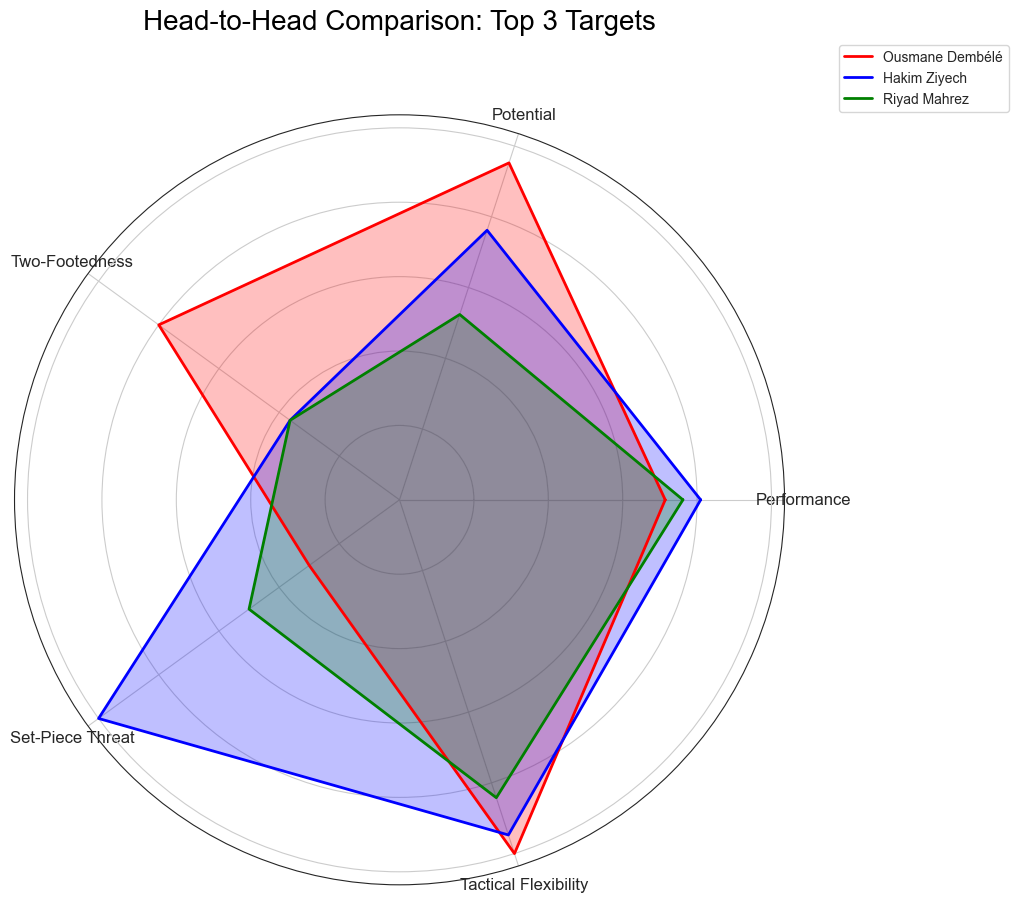

In [74]:
from scipy.stats import percentileofscore

# --- 1. Prepare ALL DataFrames ---
# This is the main list of all 21 wingers used for percentile ranking

# --- 2. Calculate Realistic Scores ---
scores = {'player_name': [], 'performance_score': [], 'potential_score': [], 'two_footed_score': [], 'set_piece_score': [], 'flexibility_score': []}
candidates = {'Ousmane Dembélé': 288230, 'Hakim Ziyech': 217111, 'Riyad Mahrez': 171424}

for name, pid in candidates.items():
    scores['player_name'].append(name)
    
    # Performance Score
    player_ga90 = summary_data[summary_data['player_id'] == pid]['ga_90'].iloc[0]
    scores['performance_score'].append(percentileofscore(summary_data['ga_90'], player_ga90))
    
    # Potential Score
    player_age = summary_data[summary_data['player_id'] == pid]['ages'].iloc[0]
    scores['potential_score'].append(100 - percentileofscore(summary_data['ages'], player_age, kind='rank'))
    
    # Two-Footed Score
    player_goals = goal_data[goal_data['player_id'] == pid]
    rf_goals = player_goals[player_goals['goal_types'] == 'Right-footed shot']['goal_type_count'].sum()
    lf_goals = player_goals[player_goals['goal_types'] == 'Left-footed shot']['goal_type_count'].sum()
    total_open_play = rf_goals + lf_goals
    if total_open_play > 0:
        weaker_foot_goals = min(rf_goals, lf_goals)
        scores['two_footed_score'].append((weaker_foot_goals / total_open_play) * 100 * 2) # Multiply by 2 to scale it up to 100
    else:
        scores['two_footed_score'].append(0)

    # Set-Piece Score
    sp_goals = goal_data[(goal_data['player_id'] == pid) & (goal_data['goal_types'].isin(['Direct free kick', 'Penalty']))]['goal_type_count'].sum()
    sp_assists = assist_data[(assist_data['player_assist_id'] == pid) & (assist_data['assist_types'].isin(['Corner', 'Free kick']))]['assist_type_count'].sum()
    scores['set_piece_score'].append(sp_goals + sp_assists)

    # Tactical Flexibility Score
    player_tactical = tactical_data[tactical_data['player_id'] == pid]
    flex_score = (player_tactical['unique_positions'].iloc[0] * 5) + (player_tactical['unique_formations'].iloc[0] * 2)
    scores['flexibility_score'].append(flex_score)

df_scores = pd.DataFrame(scores)

# Normalize the last two scores to a 0-100 scale
df_scores['set_piece_score'] = (df_scores['set_piece_score'] / df_scores['set_piece_score'].max()) * 100
df_scores['flexibility_score'] = (df_scores['flexibility_score'] / df_scores['flexibility_score'].max()) * 100

# --- 3. Plotting the Radar Chart ---
labels = ['Performance', 'Potential', 'Two-Footedness', 'Set-Piece Threat', 'Tactical Flexibility']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

def add_to_radar(player_name, color):
    stats = df_scores[df_scores['player_name'] == player_name].drop('player_name', axis=1).iloc[0].tolist()
    stats += stats[:1]
    ax.plot(angles, stats, color=color, linewidth=2, linestyle='solid', label=player_name)
    ax.fill(angles, stats, color=color, alpha=0.25)

add_to_radar('Ousmane Dembélé', 'red')
add_to_radar('Hakim Ziyech', 'blue')
add_to_radar('Riyad Mahrez', 'green')

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=12)
plt.title("Head-to-Head Comparison: Top 3 Targets", size=20, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()